In [2]:
import os
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
import numpy as np

from REStats.utils import load_SCADA, filter_outliers

In [3]:
az.style.use("arviz-darkgrid")

In [4]:
wt = load_SCADA(2020)

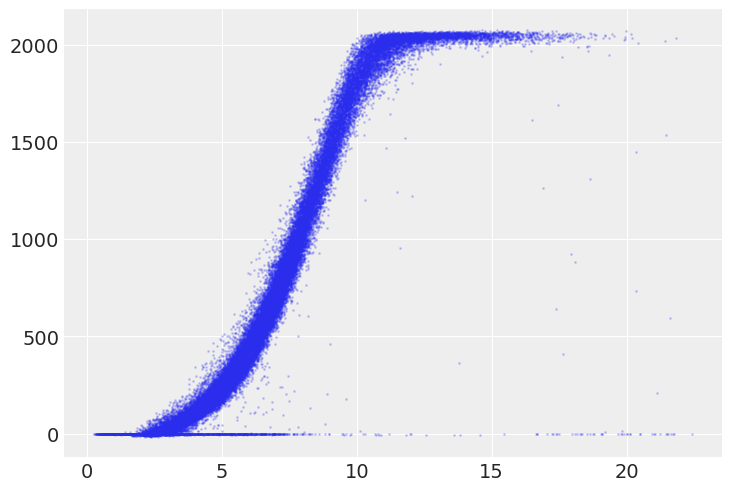

In [5]:
wt

plt.scatter(wt["Wind speed"], wt["Power"], s=1, alpha=0.2)

R2 % removed: 2.0118506269808463
R3 % removed: 3.592814371257485


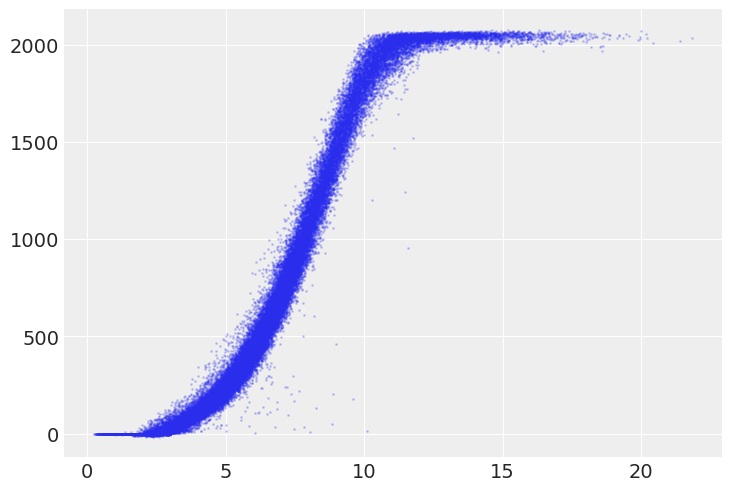

In [8]:
wt_fil = filter_outliers(wt)

plt.scatter(wt_fil["Wind speed"], wt_fil["Power"], s=1, alpha=.2)

/tmp/ipykernel_12863/1557217280.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wt_r2 = wt.dropna()[(wt["Wind speed"] >= 3) & (wt["Wind speed"] < 12)]


R2 % removed: 2.0417068577465436


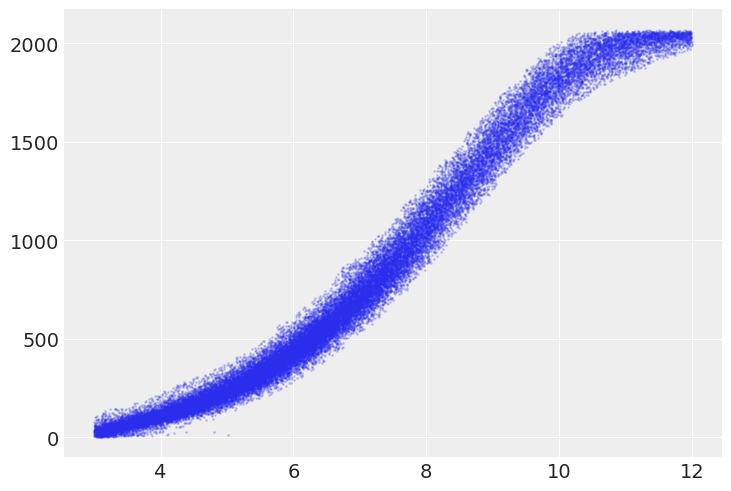

In [23]:
wt_r2 = wt.dropna()[(wt["Wind speed"] >= 3) & (wt["Wind speed"] < 12)]
p_rated = 2050

# region II filter
p_r2 = wt_r2[["Wind speed", "Power"]]
X_r2 = (p_r2 - p_r2.mean())/p_r2.std()
knn_r2 = NearestNeighbors(n_neighbors=100)
knn_r2.fit(X_r2)
distances_r2, _ = knn_r2.kneighbors(X_r2)

avg_dist_r2 = distances_r2.mean(axis=1)
[outliers_r2] = np.where(avg_dist_r2 > .075)
keep_idxs_r2 = [i for i, _ in enumerate(wt_r2.index) if i not in outliers_r2]
wt_filtered_r2 = wt_r2.iloc[keep_idxs_r2]
wt_outliers_r2 = wt_r2.iloc[outliers_r2]

wt_filtered_r2 = wt_filtered_r2[wt_filtered_r2["Power"] > (.0015*p_rated)]

print(f"R2 % removed: {len(outliers_r2)/len(wt_r2)*100}") 

plt.scatter(wt_filtered_r2["Wind speed"], wt_filtered_r2["Power"], s=1, alpha=0.2)

In [167]:
wt.head()

,Power,Wind direction,Wind speed
Date,,,
2020-01-01 00:00:00,150.984141,116.839462,3.887291
2020-01-01 00:10:00,130.414782,115.659361,3.848941
2020-01-01 00:20:00,146.401656,116.646515,4.043625
2020-01-01 00:30:00,84.296224,111.157642,3.330342
2020-01-01 00:40:00,94.994105,116.678227,3.388536


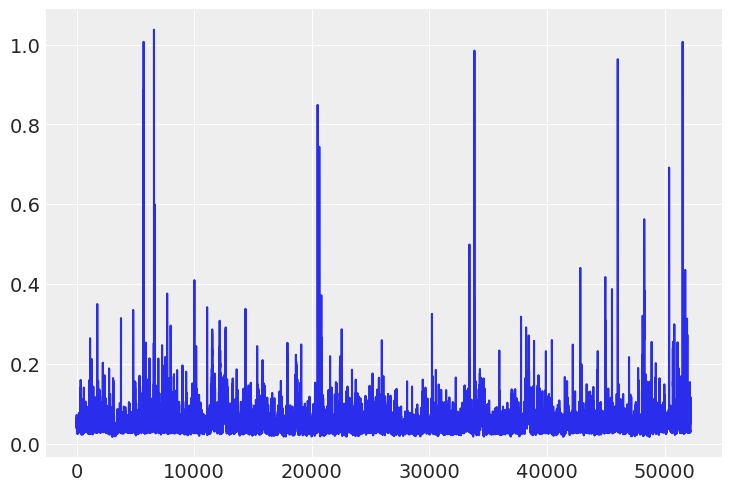

In [277]:
knn = NearestNeighbors(n_neighbors=100)
wt_f3 = wt.dropna()
wt_f3 = wt_f3[wt_f3["Wind speed"] > 12]
p = wt_f3[["Power"]]
X3 = (p - p.mean())/p.std()
# X3 = X3[:, None]
knn.fit(X3)
distances3, _ = knn.kneighbors(X3)

plt.plot(distances.mean(axis=1))

In [278]:
avg_dist3 = distances3.mean(axis=1)

[outliers3] = np.where(avg_dist3 > .075)

keep_idxs3 = [i for i, _ in enumerate(wt_f3.index) if i not in outliers3]
wt_filtered3 = wt_f3.iloc[keep_idxs3]
wt_outliers3 = wt_f3.iloc[outliers3]

len(outliers3)/len(wt_f3)

0.03592814371257485

/tmp/ipykernel_8001/2492470732.py:3: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


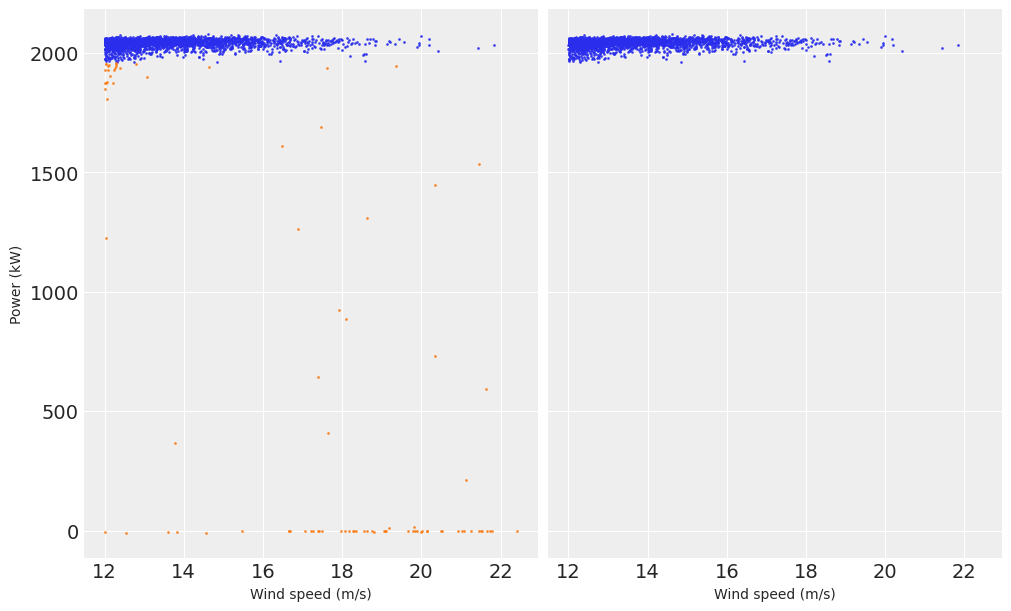

In [305]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

fig.tight_layout()

ax[0].scatter(wt_filtered3["Wind speed"], wt_filtered3["Power"], s=1, alpha=.8)
ax[0].scatter(wt_outliers3["Wind speed"], wt_outliers3["Power"], s=1, alpha=.8)

ax[0].set_xlabel("Wind speed (m/s)")
ax[0].set_ylabel("Power (kW)")

ax[1].set_xlabel("Wind speed (m/s)")

ax[1].scatter(wt_filtered3["Wind speed"], wt_filtered3["Power"], s=1, alpha=.8)

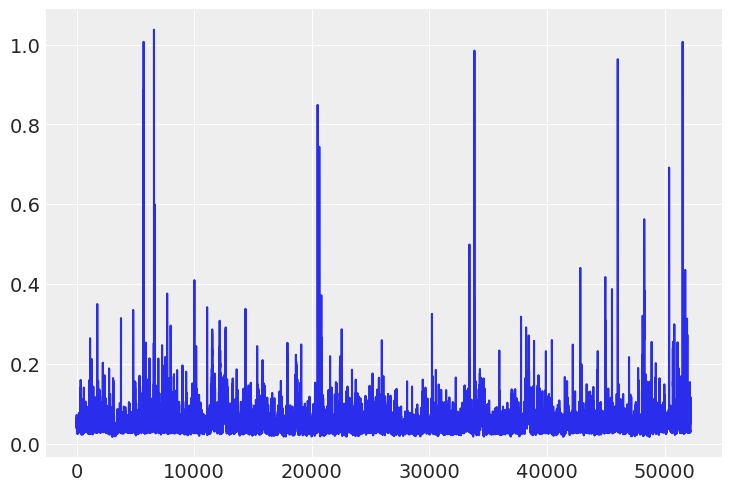

In [232]:
knn = NearestNeighbors(n_neighbors=20)
wt_f = wt.dropna()
X = (wt_f - wt_f.mean())/wt_f.std()
knn.fit(X)
distances, _ = knn.kneighbors(X)

plt.plot(distances.mean(axis=1))

In [233]:
avg_dist = distances.mean(axis=1)

[outliers] = np.where(avg_dist > .075)

len(outliers)/len(wt_f)

0.10056283023202389

In [184]:
keep_idxs = [i for i, _ in enumerate(wt_f.index) if i not in outliers]
wt_filtered = wt_f.iloc[keep_idxs]
wt_outliers = wt_f.iloc[outliers]

/tmp/ipykernel_8001/1949609686.py:3: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


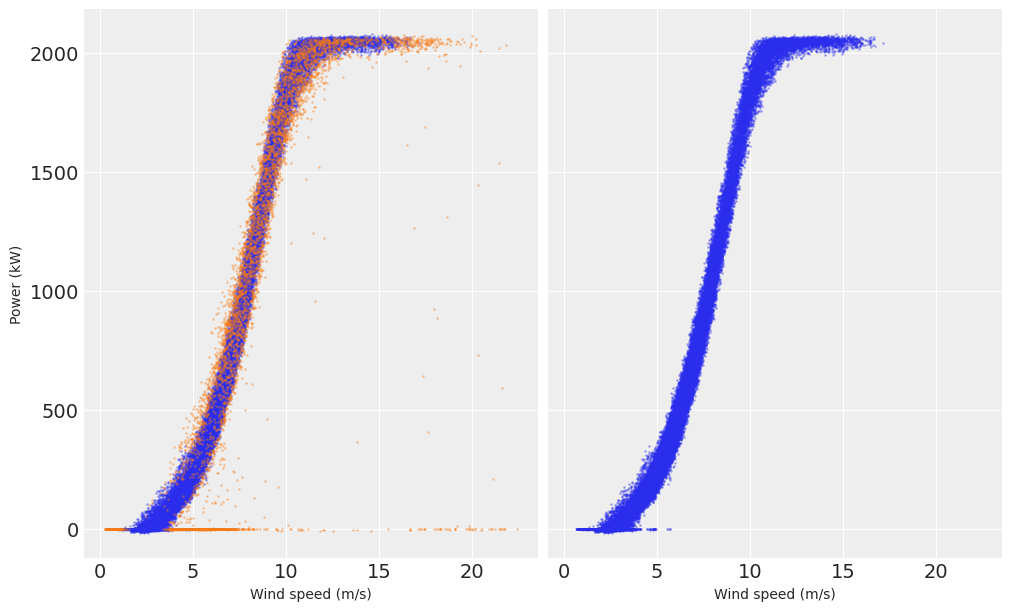

In [195]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

fig.tight_layout()

ax[0].scatter(wt_filtered["Wind speed"], wt_filtered["Power"], s=1, alpha=.3)
ax[0].scatter(wt_outliers["Wind speed"], wt_outliers["Power"], s=1, alpha=.3)

ax[0].set_xlabel("Wind speed (m/s)")
ax[0].set_ylabel("Power (kW)")

ax[1].set_xlabel("Wind speed (m/s)")

ax[1].scatter(wt_filtered["Wind speed"], wt_filtered["Power"], s=1, alpha=.3)


In [298]:
wt_filtered.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:10:00',
               '2020-01-01 00:20:00', '2020-01-01 00:30:00',
               '2020-01-01 00:40:00', '2020-01-01 00:50:00',
               '2020-01-01 01:00:00', '2020-01-01 01:10:00',
               '2020-01-01 01:20:00', '2020-01-01 01:30:00',
               ...
               '2020-12-31 22:00:00', '2020-12-31 22:10:00',
               '2020-12-31 22:20:00', '2020-12-31 22:30:00',
               '2020-12-31 22:40:00', '2020-12-31 22:50:00',
               '2020-12-31 23:00:00', '2020-12-31 23:20:00',
               '2020-12-31 23:30:00', '2020-12-31 23:50:00'],
              dtype='datetime64[ns]', name='Date', length=23012, freq=None)

In [282]:
len(outliers)

27545

In [227]:
idxs = np.random.choice(range(len(wt_filtered)), 150) # TODO: stratified split by operating region
wt_sample = wt_filtered.iloc[idxs]
wt_sample.head()

,Power,Wind direction,Wind speed
Date,,,
2020-11-18 01:00:00,1606.564447,206.024144,9.343497
2020-08-01 05:20:00,517.860316,244.942353,6.128172
2020-05-24 04:40:00,1595.453107,242.205467,9.425283
2020-03-23 05:20:00,795.725815,134.728000,7.385877
2020-09-15 22:50:00,-3.065491,62.625480,2.737500


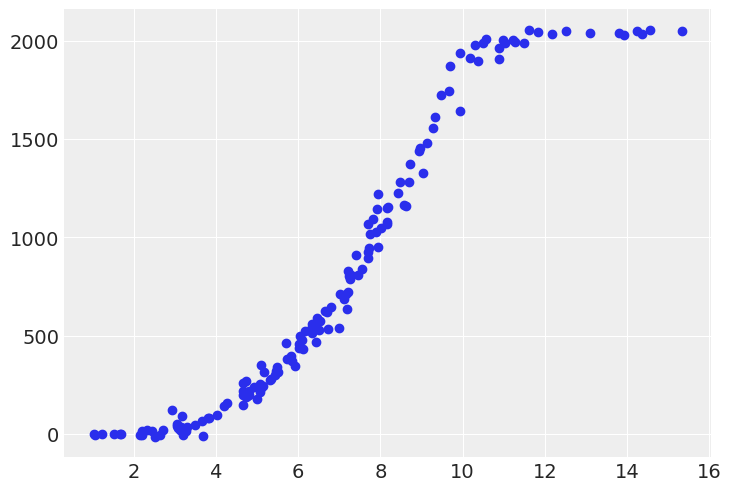

In [219]:
plt.scatter(wt_sample["Wind speed"], wt_sample["Power"])

In [220]:
X = wt_sample["Wind speed"].values[:, None]
y = wt_sample["Power"].values
y_mean = y.mean()

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Marginal(cov_func=cov_func)
    sigma = pm.HalfCauchy("sigma", beta=5)
    
    y_ = gp.marginal_likelihood("y", X=X, y=y-y_mean, sigma=sigma)
    
    idata = pm.sample(chains=2, cores=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ℓ, η, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.


In [221]:
Xnew = np.linspace(0, 20, 100)[:, None]

with model:
    fnew = gp.conditional("fnew", Xnew=Xnew)

In [222]:
with model:
    ppc = pm.sample_posterior_predictive(idata, var_names=["fnew"])

Sampling: [fnew]


array([[<Axes: title={'center': 'ℓ'}>, <Axes: title={'center': 'ℓ'}>],
       [<Axes: title={'center': 'η'}>, <Axes: title={'center': 'η'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

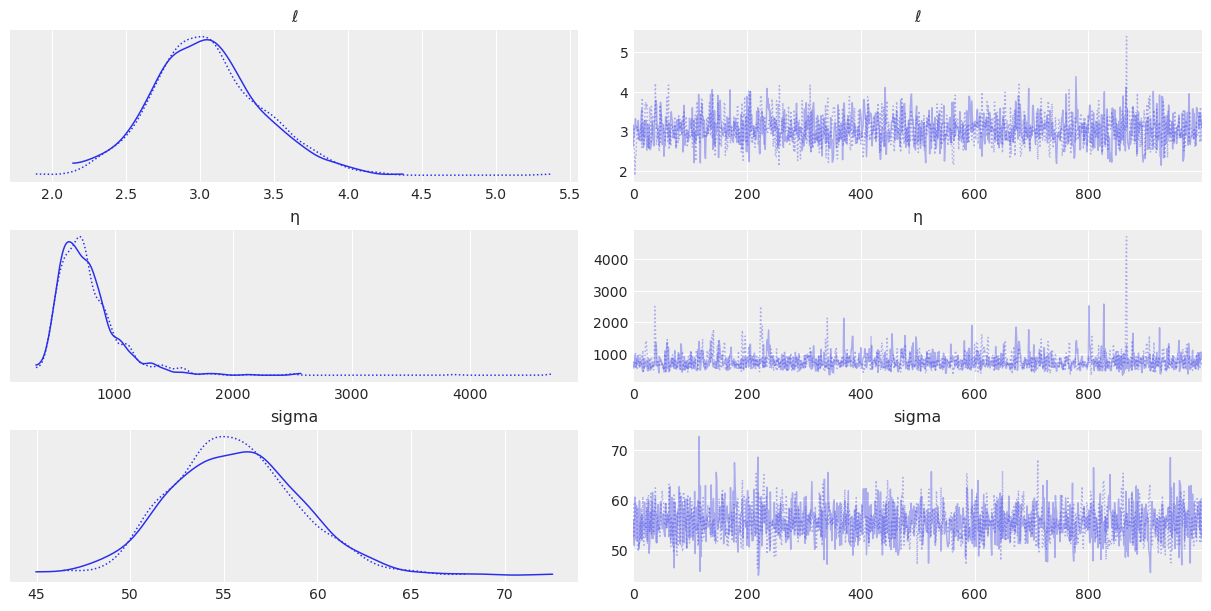

In [223]:
az.plot_trace(idata)

In [224]:
ppc.posterior_predictive.fnew[0]

<xarray.DataArray 'fnew' (draw: 1000, fnew_dim_2: 100)>
array([[-776.22570537, -787.9450326 , -795.90597725, ...,  729.89525394,
         657.0712325 ,  580.30980918],
       [-929.632293  , -899.63068291, -872.76158015, ...,  389.94866318,
         362.83780192,  338.72830057],
       [-608.2621985 , -631.82729397, -655.36679701, ...,  -65.7791676 ,
        -136.57362334, -202.72145018],
       ...,
       [-549.03376267, -586.2186276 , -619.91807867, ..., 1228.02228719,
        1210.10326675, 1189.89031363],
       [-735.51153982, -744.3905284 , -752.89242652, ...,   13.50387529,
         -54.73074421, -119.39001845],
       [-747.51674509, -763.1672822 , -776.33412874, ...,  831.36961588,
         784.45817236,  736.02089113]])
Coordinates:
    chain       int64 0
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * fnew_dim_2  (fnew_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99

Text(0, 0.5, 'Power (kW)')

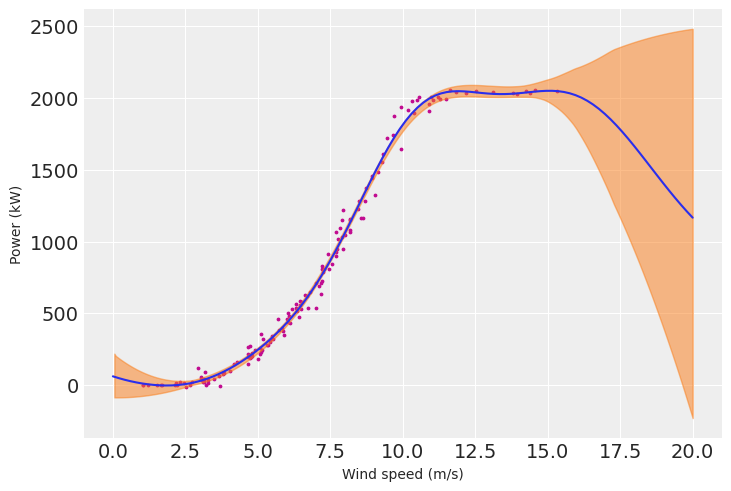

In [226]:
fig, ax = plt.subplots()

y_pred = ppc.posterior_predictive.fnew.mean(["chain", "draw"])

ax.plot(Xnew, y_pred + y_mean, color="C0")
ax.scatter(wt_sample["Wind speed"], y, s=3, color="C3")
az.plot_hdi(Xnew.flatten(), ppc.posterior_predictive.fnew + y_mean)

ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")